# Análise espectral de séries temporais através de ondaletas

Neste bloco de notas Jupyter ilustraremos a aplicação da análise de ondaletas em séries temporais. Utilizaremos o módulo [PyCWT](https://www.github.com/regeirk/pycwt). As tarefas foram subdividas nas seguintes etapas:

* Inicialização do ambiente Python
* Carregamento da série temporal S&P 500
* Visualização e estatísticas básicas
* Cálculo do espectro de ondaletas e de Fourier
* Visualização dos espectros
* Conclusões

Nestes códigos utilizaremos as bibliotecas ``numpy``, ``pandas``, ``matplotlib``, ``statsmodels`` e ``pycwt``.

In [1]:
import numpy
import pandas

from matplotlib import pyplot

import pycwt

%matplotlib inline

## Série temporal S&P 500

O S&P 500 é um abreviação para um índice composto por quinhentos ativos (ações) cotados nas bolsas de Nova York (NYSE ou NASDAQ). É um índice pondereado de valor de mercado e reflete a valorização de aproximadamente 80 % do mercado de capitais norte-americano. A série temporal utilizada neste exercício foi obtida no [Yahoo Finance](https://finance.yahoo.com/quote/%5EGSPC/history) e abrange o período entre 01 de março de 1950 e 26 de julho de 2017. Para maiores informações sobre este índices, acesse a página do [Wikipedia](https://pt.wikipedia.org/wiki/S%26P_500).

O arquivo de dados possui sete colunas. A primeira coluna (**`Date`**) será utilizada como índice da série temporal. Nós analisaremos o índice de fechamento do mercado (**``Close``**).

In [2]:
url = '../dat/GSPC.csv'
dat = pandas.read_csv(url, index_col=0, parse_dates=[0])
dat.describe()

,Open,High,Low,Close,Adj Close,Volume
count,17001.000000,17001.000000,17001.000000,17001.000000,17001.000000,1.700100e+04
mean,523.804601,526.984017,520.455754,523.937045,523.937045,8.659740e+08
std,608.032056,611.297516,604.520878,608.169986,608.169986,1.514020e+09
min,16.650000,16.660000,16.650000,16.660000,16.660000,7.400000e+05
25%,84.959999,85.599998,84.389999,84.959999,84.959999,8.390000e+06
50%,161.690002,162.160004,160.809998,161.740005,161.740005,8.313000e+07
75%,1042.589966,1049.739990,1033.780029,1042.729980,1042.729980,1.014000e+09
max,2479.969971,2481.689941,2474.939941,2477.830078,2477.830078,1.145623e+10


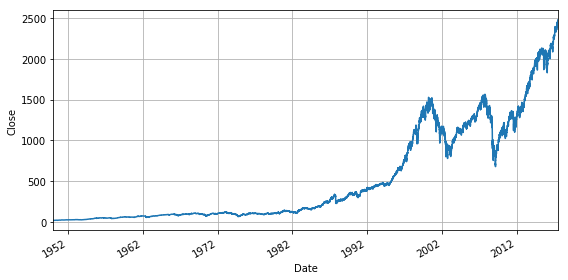

In [3]:
fig = pyplot.figure(figsize=[8, 4])
ax = dat['Close'].plot()
ax.set_ylabel('Close')
ax.grid('on')
fig.tight_layout()

Nota-se que o índice possui um aumento com tendência exponencial e dois instantes de queda abrupta -- durante as crises de 2002 e 2008. A série temporal tende a aumentar. Isto dificulta a análise espectral, pois assume-se que os dados são estacionários. Vamos fazer uma transformação logarítmica da série original.

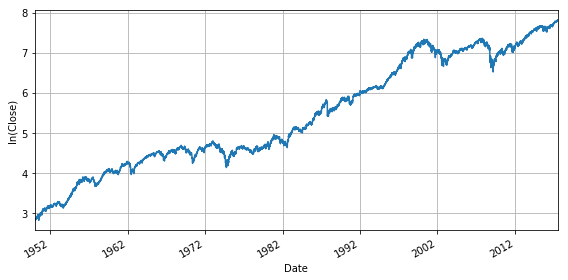

In [4]:
dat['LnClose'] = dat['Close'].apply(lambda x: numpy.log(x))

fig = pyplot.figure(figsize=[8, 4])
ax = dat['LnClose'].plot()
ax.set_ylabel('ln(Close)')
ax.grid('on')
fig.tight_layout()

A série transformada apresenta uma certa tendência de aumento linear. Vamos determinar os parâmetros que melhor ajustam uma reta aos dados.

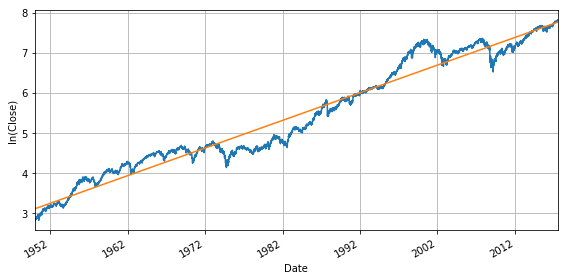

In [5]:
p = numpy.polyfit(dat.index.values.astype(float), dat['LnClose'].values, 1)
dat['LnCloseTrend'] = numpy.polyval(p, dat.index.values.astype(float))

fig = pyplot.figure(figsize=[8, 4])
ax = dat['LnClose'].plot()
_ = dat['LnCloseTrend'].plot(ax=ax)
ax.set_ylabel('ln(Close)')
ax.grid('on')
fig.tight_layout()

No próximo passo vamos remover a tendência da série temporal transformada.

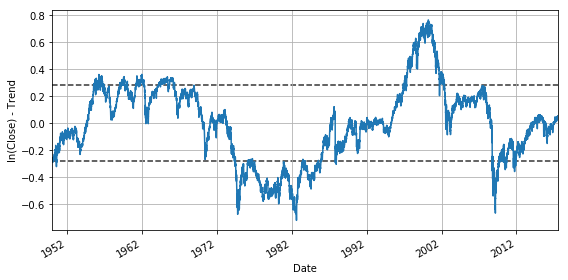

In [6]:
dat['LnCloseDetrend'] = dat['LnClose'] - dat['LnCloseTrend']

fig = pyplot.figure(figsize=[8, 4])
ax = dat['LnCloseDetrend'].plot()
ax.axhline(dat['LnCloseDetrend'].std(), color='#333333', ls='--', zorder=1)
ax.axhline(-dat['LnCloseDetrend'].std(), color='#333333', ls='--', zorder=1)
ax.set_ylabel('ln(Close) - Trend')
ax.grid('on')
fig.tight_layout()

Esta série temporal possui ruídos causados pelas flutuações diárias. Estas flutuações de alta frequência podem ser suavizados aplicando-se um filtro de janela móvel. Neste caso, aplicaremos a janela móvel do tipo [Blackman](https://en.wikipedia.org/wiki/Window_function#Blackman_windows)

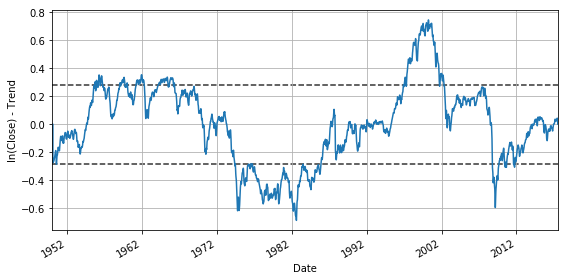

In [7]:
dat['LnCloseDetrendSmooth'] = dat['LnCloseDetrend'].rolling(33, center=True, win_type='blackman').mean().fillna(0)

fig = pyplot.figure(figsize=[8, 4])
ax = dat['LnCloseDetrendSmooth'].plot()
ax.axhline(dat['LnCloseDetrend'].std(), color='#333333', ls='--', zorder=1)
ax.axhline(-dat['LnCloseDetrend'].std(), color='#333333', ls='--', zorder=1)
ax.set_ylabel('ln(Close) - Trend')
ax.grid('on')
fig.tight_layout()

## A transformada de ondaletas

Vamos seguir os passos sugeridos no [tutorial da biblioteca PyCWT](http://regeirk.github.io/pycwt/tutorial.html) e preparar a análise de ondaletas segundo Torrence e Compo (1998). Preparamos alguns parâmetros. Por causa do tratamento anterior, a série temporal que utilizaremos terá média nula. Normalizaremos a série dividindo-a pelo desvio padrão. Isso permite que os espectros obtidos sejam comparáveis com outros espectros.

In [8]:
t = dat.index.values
y = dat['LnCloseDetrendSmooth'].values
std = y.std()  # Desvio padrão
var = std ** 2  # Variância
y_norm = y / std
N = len(y_norm)

# A ondaleta-mãe
mother = pycwt.Morlet(6)
# Intervalo de amostragem em anos (não consideramos finais de semana, tampouco
# feriados)
dt = 1 / 365  
# Escala inicial
s0 = 15 * dt
# Duas sub-oitavas por oitava
dj = 1 / 4
# Onze potências de dois, com `dj` sub-oitavas
J = 8 / dj
# Coeficiente de autocorrelação de lag-1 para estimar ruído
alpha, _, _ = pycwt.ar1(y_norm)

print('O coeficiente the correlação de lag-1 é {:.2f}'.format(alpha))

O coeficiente the correlação de lag-1 é 1.00


Em seguida calculamos a transformada de ondaletas, os espectros de potência normalizados de ondaleta e de Fourier, bem como os períodos de Fourier equivalentes para cada escala.

In [9]:
wave, scales, freqs, coi, fft, fftfreqs = pycwt.cwt(y_norm, dt, dj, s0, J, 
                                                    mother)

power = (numpy.abs(wave)) ** 2
fft_power = numpy.abs(fft) ** 2
period = 1 / freqs

# Retificação do espectro de potência segundo Liu et al. (2007)
power /= scales[:, None]

Agora os testes de significância.

In [10]:
signif, fft_theor = pycwt.significance(1.0, dt, scales, 0, alpha, 
                                       significance_level=0.95, wavelet=mother)
sig95 = numpy.ones([1, N]) * signif[:, None]
sig95 = power / sig95

E o espectro de ondaleta global.

In [11]:
glbl_power = power.mean(axis=1)
dof = N - scales  # Correção nas bordas
glbl_signif, tmp = pycwt.significance(var, dt, scales, 1, alpha, 
                                      significance_level=0.95, dof=dof, 
                                      wavelet=mother)

Finalmente estamos prontos para exibir nossos resultados.

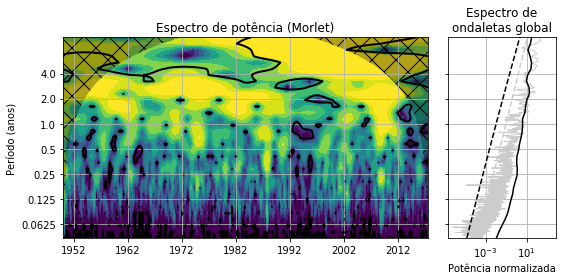

In [12]:
fig = pyplot.figure(figsize=[8, 4])
ax = pyplot.subplot2grid((1, 4), (0, 0), colspan=3)
bx = pyplot.subplot2grid((1, 4), (0, 3), colspan=1, sharey=ax)

# Espectro de potência de ondaletas
# ---------------------------------
levels = [2. ** i for i in numpy.arange(-4, 5)]
ax.contourf(t, numpy.log2(period), numpy.log2(power), numpy.log2(levels), 
            extend='both')

extent = [t.min(), t.max(), 0, max(period)]
ax.contour(t, numpy.log2(period), sig95, [-99, 1], colors='k', linewidths=2,
           extent=extent)
DT = numpy.timedelta64(1, 'D')
ax.fill(numpy.concatenate([t, t[-1:] + DT, t[-1:] + DT,
                           t[:1] - DT, t[:1] - DT]),
        numpy.concatenate([numpy.log2(coi), [1e-9], numpy.log2(period[-1:]),
                           numpy.log2(period[-1:]), [1e-9]]),
        'k', alpha=0.3, hatch='x')
ax.set_title('Espectro de potência ({})'.format(mother.name))
ax.set_ylabel('Período (anos)')
#
ylim = [numpy.ceil(numpy.log2(period.min())),
        numpy.floor(numpy.log2(period.max()))]
ax.set_ylim(ylim)
Yticks = 2 ** numpy.arange(*ylim)
ax.set_yticks(numpy.log2(Yticks))
ax.set_yticklabels(Yticks)

# Espectro de ondaletas global e espectro de Fourier
# --------------------------------------------------
bx.semilogx(fft_power, numpy.log2(1./fftfreqs), '-', color='#cccccc',
            linewidth=1.)
bx.semilogx(glbl_power, numpy.log2(period), 'k-', linewidth=1.5)
bx.semilogx(glbl_signif, numpy.log2(period), 'k--')
bx.semilogx(fft_theor, numpy.log2(period), '--', color='#cccccc')
bx.set_title('Espectro de\nondaletas global')
bx.set_xlabel(r'Potência normalizada')
#bx.set_xlim([0, 0.1])
bx.set_ylim(numpy.log2([period.min(), period.max()]))
bx.set_yticks(numpy.log2(Yticks))
bx.set_yticklabels(Yticks)
pyplot.setp(bx.get_yticklabels(), visible=False)

# Perfumarias
ax.grid('on')
bx.grid('on')
pyplot.tight_layout()